### Notebook description
- I created this notebook to easily create a maze. This makes it easier to write down / communicate what maze someone is talking about. 

In [1]:
from IPython import get_ipython
ipython = get_ipython()
ipython.run_line_magic("load_ext", "autoreload")
ipython.run_line_magic("autoreload", "2")


In [2]:
import sys
sys.path.append('../../..')

import numpy as np
from maze_dataset.plotting import MazePlot, plot_dataset_mazes, PathFormat
from maze_dataset import LatticeMaze, SolvedMaze, MazeDataset, MazeDatasetConfig
import matplotlib.pyplot as plt


from maze_dataset.tokenization import MazeTokenizer, TokenizationMode
tokenizer = MazeTokenizer()

# Create a nice maze plot from scratch

## 1. Go Notion, and create a table that represents the maze such as the one below

| 〇 | 🟩 | 〇 | 🟩 | 〇 |
| --- | --- | --- | --- | --- |
| 🟩 | 🟥 | 🟥 | 🟥 | 🟩 |
| 〇 | 🟩 | 〇 | 🟩 | 〇 |
| 🟩 | 🟥 | 🟩 | 🟥 | 🟩 |
| 〇 | 🟥 | 〇 | 🟥 | 〇 |


Or better:

| 〇 | 🟩 | 〇 | 🟩 | 〇 |
| --- | --- | --- | --- | --- |
| 🟩 |   | 🟥 |   | 🟩 |
| 〇 | 🟩 | 〇 | 🟩 | 〇 |
| 🟩 |   | 🟩 |  | 🟩 |
| 〇 | 🟥 | 〇 | 🟥 | 〇 |


According to the mapping:
- "🟥" is a   Wall
-  "〇"  is a Cell
-  "🟩" is a Path

Options:
- You can create it with outer walls or without.
- You can make the maze as large as you want, but I think it should be square?

Once you have such a maze, copy it and put it in the `maze_str` variable, see example below
    

## 2. Code to convert the table structure (which is a string), to a `MazePlot()`

In [3]:
def parse_emoji_maze_to_matrix(maze_str):
    # Split the string into lines and filter out the separator lines
    lines = [line.strip().replace(" ", "").replace("||", "|🟥|") for line in maze_str.split('\n') if "---" not in line]
    
    # Extract emojis from each line
    maze_matrix = [[char for char in line if char in "🟥〇🟩"] for line in lines]
    
    return maze_matrix


def emoji_maze_str_to_adj_list_adapted(maze_str):
    maze_matrix = parse_emoji_maze_to_matrix(maze_str)
    
    # Translate emojis to a simpler format for processing
    maze_map = { 
        "🟥": "W",  # Wall
        "〇": "C",  # Cell
        "🟩": "P"   # Path
    }
    
    # Finding cells (C) and mapping them to their actual coordinates
    processed_maze = [[maze_map[cell] for cell in row] for row in maze_matrix]
    cell_positions = {(i, j) for i, row in enumerate(processed_maze) for j, cell in enumerate(row) if cell == "C"}
    adjacency_list = set() # Connections based on paths (P) between cells
    
    # Adjust the directions to account for potential direct edges without outer walls
    directions = [(0, 2), (2, 0), (-2, 0), (0, -2)]  # Skipping one cell in each direction to account for paths
    
    # Adjust function to check for path presence without assuming walls
    def is_path_between(ci, cj, ni, nj):
        if 0 <= (ci + ni) // 2 < len(processed_maze) and 0 <= (cj + nj) // 2 < len(processed_maze[0]):
            return processed_maze[(ci + ni) // 2][(cj + nj) // 2] == "P"
        return False
    
    min_x = min([pos[0] for pos in cell_positions])
    min_y = min([pos[1] for pos in cell_positions])
    
    # Calculate grid size based on cell positions
    for ci, cj in cell_positions:
        for dx, dy in directions:
            ni, nj = ci + dx, cj + dy
            if (ni, nj) in cell_positions and is_path_between(ci, cj, ni, nj):
                c_mapped = ((ci - min_x) // 2, (cj - min_y) // 2)
                n_mapped = ((ni - min_x) // 2, (nj - min_y) // 2)
                adjacency_list.add(f"({c_mapped[0]},{c_mapped[1]}) <--> ({n_mapped[0]},{n_mapped[1]})")
    
    adj_list_str = "<ADJLIST_START> " + " ; ".join(sorted(adjacency_list)) + " <ADJLIST_END>"
    return adj_list_str

In [4]:

# option with outer walls
emoji_maze_str = """| 🟥 | 🟥 | 🟥 | 🟥 | 🟥 | 🟥 | 🟥 |
| --- | --- | --- | --- | --- | --- | --- |
| 🟥 | 〇 | 🟥 | 〇 | 🟩 | 〇 | 🟥 |
| 🟥 | 🟩 | 🟥 | 🟥 | 🟩 | 🟩 | 🟥 |
| 🟥 | 〇 | 🟩 | 〇 | 🟩 | 〇 | 🟥 |
| 🟥 | 🟩 | 🟩 | 🟩 | 🟩 | 🟩 | 🟥 |
| 🟥 | 〇 | 🟥 | 〇 | 🟥 | 〇 | 🟥 |
| 🟥 | 🟥 | 🟥 | 🟥 | 🟥 | 🟥 | 🟥 |"""


# option without outer walls
emoji_maze_str = """| 〇 | 🟩 | 〇 | 🟥 | 〇 |
| --- | --- | --- | --- | --- |
| 🟩 |   | 🟥 |   | 🟩 |
| 〇 | 🟩 | 〇 | 🟩 | 〇 |
| 🟩 |   | 🟩 |  | 🟩 |
| 〇 | 🟥 | 〇 | 🟥 | 〇 |"""


# Convert and return the maze as an adjacency list string with adaptations
adj_list_str_fixed = emoji_maze_str_to_adj_list_adapted(emoji_maze_str)
print(len(adj_list_str_fixed), adj_list_str_fixed)


331 <ADJLIST_START> (0,0) <--> (0,1) ; (0,0) <--> (1,0) ; (0,1) <--> (0,0) ; (0,2) <--> (1,2) ; (1,0) <--> (0,0) ; (1,0) <--> (1,1) ; (1,0) <--> (2,0) ; (1,1) <--> (1,0) ; (1,1) <--> (1,2) ; (1,1) <--> (2,1) ; (1,2) <--> (0,2) ; (1,2) <--> (1,1) ; (1,2) <--> (2,2) ; (2,0) <--> (1,0) ; (2,1) <--> (1,1) ; (2,2) <--> (1,2) <ADJLIST_END>


In [5]:
start_coor = "(2,1)"
end_coor = "(0,1)"
# adj_list_str_fixed = adj_list_str_fixed + " <ORIGIN_START> (2,1) <ORIGIN_END> <TARGET_START> (0,1) <TARGET_END>"
adj_list_str_fixed  = adj_list_str_fixed + f" <ORIGIN_START> {start_coor} <ORIGIN_END> <TARGET_START> {end_coor} <TARGET_END>"

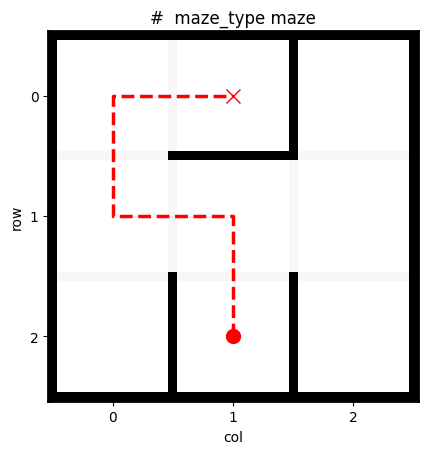

In [6]:
ref_maze = LatticeMaze.from_tokens(adj_list_str_fixed, maze_tokenizer=tokenizer)
MazePlot(ref_maze).plot( title="# " + " " + "maze_type" + " maze")


# Other options - add (partial) path:

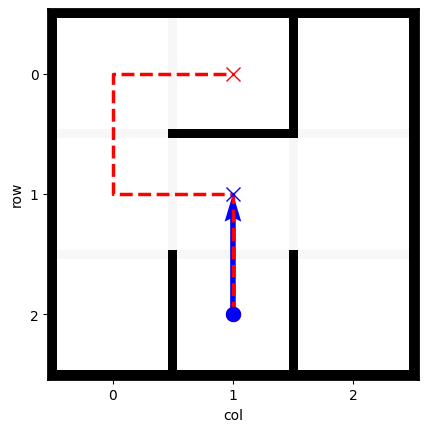

In [7]:
pred_path1 = [(2, 1), (1,1)]
(
MazePlot(ref_maze)
    .add_predicted_path(pred_path1, color="blue")
    .plot()
)
plt.show()

# Plot distance till goal

In [8]:

test_maze_str = """| 🟥 | 🟥 | 🟥 | 🟥 | 🟥 | 🟥 | 🟥 | 🟥 | 🟥 | 🟥 | 🟥 | 🟥 | 🟥 |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| 🟥 | 〇 | 🟩 | 〇 | 🟥 | 〇 | 🟩 | 〇 | 🟥 | 〇 | 🟩 | 〇 | 🟥 |
| 🟥 | 🟩 |  | 🟥 |  | 🟩 |  | 🟥 |  | 🟩 |  | 🟥 | 🟥 |
| 🟥 | 〇 | 🟩 | 〇 | 🟩 | 〇 | 🟥 | 〇 | 🟩 | 〇 | 🟥 | 〇 | 🟥 |
| 🟥 | 🟥 |  | 🟥 |  | 🟩 |  | 🟩 |  | 🟩 |  | 🟩 | 🟥 |
| 🟥 | 〇 | 🟥 | 〇 | 🟥 | 〇 | 🟩 | 〇 | 🟥 | 〇 | 🟩 | 〇 | 🟥 |
| 🟥 | 🟩 |  | 🟩 |  | 🟥 |  | 🟥 |  | 🟩 |  | 🟩 | 🟥 |
| 🟥 | 〇 | 🟩 | 〇 | 🟩 | 〇 | 🟩 | 〇 | 🟩 | 〇 | 🟥 | 〇 | 🟥 |
| 🟥 | 🟩 |  | 🟥 |  | 🟩 |  | 🟩 |  | 🟥 |  | 🟩 | 🟥 |
| 🟥 | 〇 | 🟥 | 〇 | 🟩 | 〇 | 🟥 | 〇 | 🟩 | 〇 | 🟩 | 〇 | 🟥 |
| 🟥 | 🟩 |  | 🟩 |  | 🟩 |  | 🟩 |  | 🟩 |  | 🟥 | 🟥 |
| 🟥 | 〇 | 🟩 | 〇 | 🟥 | 〇 | 🟩 | 〇 | 🟥 | 〇 | 🟩 | 〇 | 🟥 |
| 🟥 | 🟥 | 🟥 | 🟥 | 🟥 | 🟥 | 🟥 | 🟥 | 🟥 | 🟥 | 🟥 | 🟥 | 🟥 |
"""

test_maze_str = test_maze_str.replace("|  |", "🟥")



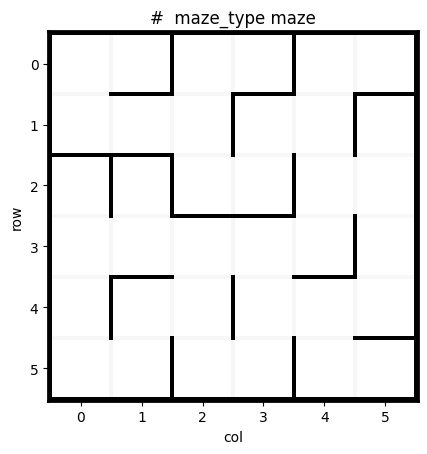

In [9]:
adj_list_str_fixed = emoji_maze_str_to_adj_list_adapted(test_maze_str)
ref_maze = LatticeMaze.from_tokens(adj_list_str_fixed, maze_tokenizer=tokenizer)
plot_maze = MazePlot(ref_maze)
plot_maze.plot( title="# " + " " + "maze_type" + " maze")


In [10]:
import numpy as np

def calculate__shortest_paths(ref_maze):
    shortest_path_lengths = np.zeros((6, 6))

    for i in range(6):
        for j in range(6):
            path_array = ref_maze.find_shortest_path((i, j), (0,5))
            shortest_path_lengths[i, j] = len(path_array)

    return shortest_path_lengths

# Call the function
path_lengts = calculate__shortest_paths(ref_maze)

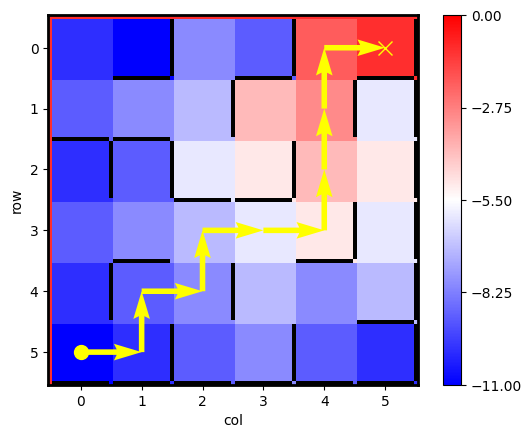

In [11]:
adj_list_str_fixed = emoji_maze_str_to_adj_list_adapted(test_maze_str)
ref_maze = LatticeMaze.from_tokens(adj_list_str_fixed, maze_tokenizer=tokenizer)
true_path = ref_maze.find_shortest_path((5,0), (0,5))
MazePlot(ref_maze).add_node_values(-path_lengts, color_map="bwr").add_predicted_path(true_path, color="yellow").plot()


# Plot maze as connections in stead of walls

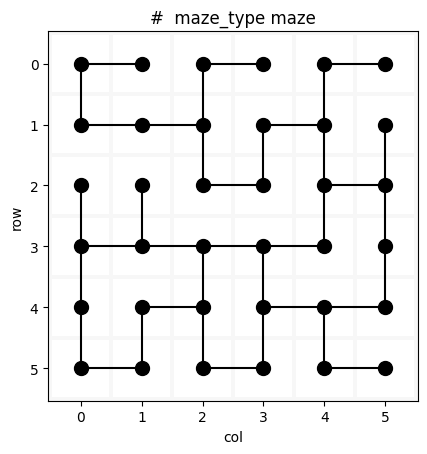

In [12]:
adj_list_str_fixed = emoji_maze_str_to_adj_list_adapted(test_maze_str)
ref_maze = LatticeMaze.from_tokens(adj_list_str_fixed, maze_tokenizer=tokenizer)
MazePlot(ref_maze).plot_with_connections( title="# " + " " + "maze_type" + " maze")


# plot_with_connections

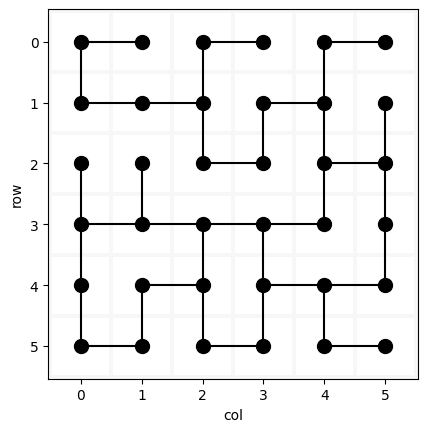

In [13]:
MazePlot(ref_maze).plot_with_connections()
# title="# " + " " + "maze_type" + " maze")
